In [3]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

import cv2
import statistics as stats
from scipy.spatial import distance
import numpy as np
import math
import torch
from torchvision.utils import save_image
from os import makedirs

# GAN

Resource: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [4]:
def jsd_calculation(true, fake, display=False):

    true_adjusted = true.reshape(64*3*32*32)
    fake_adjusted = fake.reshape(64*3*32*32)

    # Normalize true and fake
    true_adjusted = cv2.normalize(np.array(true_adjusted), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    fake_adjusted = cv2.normalize(np.array(fake_adjusted), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    true_adjusted = np.array([elem[0] for elem in true_adjusted]).reshape(64,3*32*32)
    fake_adjusted = np.array([elem[0] for elem in fake_adjusted]).reshape(64,3*32*32)

    if display: print(true_adjusted[0:1])
    if display: print(fake_adjusted[0:1])
    
    # Get JSD
    jsd = distance.jensenshannon(true_adjusted, fake_adjusted, base=2.0, axis=1)

    # Remove inf values
    jsd_adjusted = [v for v in jsd if not math.isnan(v) and not math.isinf(v)]

    return stats.mean(jsd_adjusted)

# output = jsd_calculation(true, fake, display=False)
# print(output)

In [5]:
def save_Sample(sample, title):

  sample_subset = sample.reshape(64*3*32*32)
  sample_subset = cv2.normalize(np.array(sample_subset), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  sample_subset = np.array([elem[0] for elem in sample_subset]).reshape(64,3,32,32)
  
  myX = list()
  for elem in sample_subset:
    elem = np.array(elem).reshape(3,32,32)
    myX.append(torch.Tensor(elem))

  save_image(myX, '/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/' +title+ '.png')

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, jsd):
	# plot loss
	pyplot.subplot(3, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(3, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
 	# plot jsd
	pyplot.subplot(3, 1, 3)
	pyplot.plot(jsd, label='jsd')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/cifar10_gan/cifar10_trainingLoss.png')
	pyplot.close()
 
def summarize_performance(step, g_model, latent_dim, n_samples=64):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(8 * 8):
		# define subplot
		pyplot.subplot(8, 8, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	pyplot.savefig('results_baseline/generated_plot_%03d.png' % (step+1))
	pyplot.close()
	# save the generator model
	g_model.save('results_baseline/model_%03d.h5' % (step+1))
	save_Sample(X, 'cifar10_gan/cifar10_sample_%03d.h5' % (step+1))

In [16]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist, jsd = list(), list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
			# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
		d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
		d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		jsd_epoch = jsd_calculation(X_real, X_fake)
			# summarize loss on this batch
		print('>%d out of %d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d jsd=%d' %
			(i+1, n_steps, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2), int(100*jsd_epoch)))
   		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		a1_hist.append(d_acc1)
		a2_hist.append(d_acc2)
		jsd.append(jsd_epoch)
		# evaluate the model performance, sometimes
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, jsd)

# CIFAR 10

In [17]:
makedirs('results_baseline', exist_ok=True)

latent_dim = 200

d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 4ms/step
>1 out of 7800, d1=0.691, d2=0.697 g=0.690, a1=54, a2=0 jsd=21
2/2 [==============================] - 0s 4ms/step
>2 out of 7800, d1=0.632, d2=0.701 g=0.686, a1=100, a2=0 jsd=22
2/2 [==============================] - 0s 5ms/step
>3 out of 7800, d1=0.564, d2=0.711 g=0.677, a1=100, a2=0 jsd=22
2/2 [==============================] - 0s 5ms/step
>4 out of 7800, d1=0.471, d2=0.731 g=0.662, a1=100, a2=0 jsd=24
2/2 [==============================] - 0s 4ms/step
>5 out of 7800, d1=0.360, d2=0.772 g=0.640, a1=100, a2=0 jsd=26
2/2 [==============================] - 0s 4ms/step
>6 out of 7800, d1=0.251, d2=0.810 g=0.635, a1=100, a2=0 jsd=25
2/2 [==============================] - 0s 4ms/step
>7 out of 7800, d1=0.179, d2=0.805 g=0.665, a1=100, a2=0 jsd=28
2/2 [==============================] - 0s 4ms/step
>8 out of 7800, d1=0.134, d2=0.745 g=0.732, a1=100, a2=0 jsd=27
2/2 [==============================] - 0s 4ms/step
>9 out of 7800, d1=0.100, d2=0

2/2 [==============================] - 0s 4ms/step
>391 out of 7800, d1=0.710, d2=0.525 g=2.729, a1=48, a2=70 jsd=31
2/2 [==============================] - 0s 4ms/step
>392 out of 7800, d1=0.863, d2=0.416 g=2.356, a1=46, a2=84 jsd=31
2/2 [==============================] - 0s 4ms/step
>393 out of 7800, d1=0.821, d2=0.594 g=2.600, a1=51, a2=67 jsd=32
2/2 [==============================] - 0s 4ms/step
>394 out of 7800, d1=1.117, d2=0.348 g=2.274, a1=29, a2=92 jsd=35
2/2 [==============================] - 0s 4ms/step
>395 out of 7800, d1=0.859, d2=0.382 g=2.212, a1=51, a2=89 jsd=36
2/2 [==============================] - 0s 4ms/step
>396 out of 7800, d1=1.034, d2=0.461 g=1.891, a1=40, a2=85 jsd=33
2/2 [==============================] - 0s 4ms/step
>397 out of 7800, d1=0.791, d2=0.373 g=2.028, a1=51, a2=92 jsd=33
2/2 [==============================] - 0s 4ms/step
>398 out of 7800, d1=0.814, d2=0.301 g=2.041, a1=46, a2=98 jsd=34
2/2 [==============================] - 0s 5ms/step
>399 out of 7

2/2 [==============================] - 0s 4ms/step
>781 out of 7800, d1=0.901, d2=0.584 g=1.406, a1=45, a2=65 jsd=35
2/2 [==============================] - 0s 5ms/step
>782 out of 7800, d1=0.928, d2=0.729 g=1.396, a1=43, a2=51 jsd=36
2/2 [==============================] - 0s 4ms/step
>783 out of 7800, d1=1.057, d2=0.673 g=1.309, a1=37, a2=70 jsd=36
2/2 [==============================] - 0s 4ms/step
>784 out of 7800, d1=0.984, d2=0.588 g=1.279, a1=42, a2=73 jsd=38
2/2 [==============================] - 0s 4ms/step
>785 out of 7800, d1=0.889, d2=0.556 g=1.244, a1=42, a2=81 jsd=40
2/2 [==============================] - 0s 4ms/step
>786 out of 7800, d1=0.861, d2=0.577 g=1.216, a1=35, a2=73 jsd=39
2/2 [==============================] - 0s 4ms/step
>787 out of 7800, d1=0.868, d2=0.560 g=1.255, a1=34, a2=78 jsd=39
2/2 [==============================] - 0s 4ms/step
>788 out of 7800, d1=0.851, d2=0.472 g=1.349, a1=37, a2=93 jsd=40
2/2 [==============================] - 0s 5ms/step
>789 out of 7

2/2 [==============================] - 0s 4ms/step
>1171 out of 7800, d1=0.622, d2=0.533 g=1.161, a1=59, a2=85 jsd=31
2/2 [==============================] - 0s 4ms/step
>1172 out of 7800, d1=0.517, d2=0.606 g=1.199, a1=70, a2=68 jsd=31
2/2 [==============================] - 0s 4ms/step
>1173 out of 7800, d1=0.557, d2=0.490 g=1.364, a1=67, a2=87 jsd=31
2/2 [==============================] - 0s 4ms/step
>1174 out of 7800, d1=0.423, d2=0.484 g=1.421, a1=75, a2=89 jsd=31
2/2 [==============================] - 0s 4ms/step
>1175 out of 7800, d1=0.463, d2=0.533 g=1.426, a1=70, a2=79 jsd=32
2/2 [==============================] - 0s 4ms/step
>1176 out of 7800, d1=0.539, d2=0.532 g=1.403, a1=62, a2=82 jsd=30
2/2 [==============================] - 0s 4ms/step
>1177 out of 7800, d1=0.621, d2=0.754 g=1.376, a1=62, a2=59 jsd=31
2/2 [==============================] - 0s 4ms/step
>1178 out of 7800, d1=0.842, d2=0.734 g=1.220, a1=48, a2=56 jsd=31
2/2 [==============================] - 0s 4ms/step
>1179

2/2 [==============================] - 0s 4ms/step
>1561 out of 7800, d1=0.571, d2=0.521 g=1.167, a1=62, a2=84 jsd=33
2/2 [==============================] - 0s 4ms/step
>1562 out of 7800, d1=0.658, d2=0.613 g=1.248, a1=54, a2=73 jsd=32
2/2 [==============================] - 0s 5ms/step
>1563 out of 7800, d1=0.550, d2=0.472 g=1.130, a1=67, a2=84 jsd=33
2/2 [==============================] - 0s 4ms/step
>1564 out of 7800, d1=0.593, d2=0.485 g=1.093, a1=64, a2=85 jsd=32
2/2 [==============================] - 0s 4ms/step
>1565 out of 7800, d1=0.701, d2=0.618 g=0.992, a1=53, a2=70 jsd=32
2/2 [==============================] - 0s 4ms/step
>1566 out of 7800, d1=0.578, d2=0.674 g=1.041, a1=64, a2=70 jsd=31
2/2 [==============================] - 0s 4ms/step
>1567 out of 7800, d1=0.586, d2=0.651 g=1.109, a1=65, a2=65 jsd=32
2/2 [==============================] - 0s 4ms/step
>1568 out of 7800, d1=0.665, d2=0.625 g=1.154, a1=62, a2=70 jsd=33
2/2 [==============================] - 0s 4ms/step
>1569

2/2 [==============================] - 0s 5ms/step
>1951 out of 7800, d1=0.661, d2=0.628 g=1.399, a1=70, a2=68 jsd=27
2/2 [==============================] - 0s 4ms/step
>1952 out of 7800, d1=0.728, d2=0.667 g=1.294, a1=51, a2=65 jsd=28
2/2 [==============================] - 0s 4ms/step
>1953 out of 7800, d1=0.797, d2=0.745 g=1.426, a1=50, a2=57 jsd=29
2/2 [==============================] - 0s 4ms/step
>1954 out of 7800, d1=0.813, d2=0.447 g=1.407, a1=43, a2=82 jsd=30
2/2 [==============================] - 0s 4ms/step
>1955 out of 7800, d1=0.706, d2=0.599 g=1.533, a1=50, a2=68 jsd=30
2/2 [==============================] - 0s 4ms/step
>1956 out of 7800, d1=0.688, d2=0.390 g=1.821, a1=50, a2=89 jsd=30
2/2 [==============================] - 0s 5ms/step
>1957 out of 7800, d1=0.664, d2=0.291 g=1.943, a1=57, a2=100 jsd=31
2/2 [==============================] - 0s 4ms/step
>1958 out of 7800, d1=0.484, d2=0.254 g=1.876, a1=71, a2=100 jsd=32
2/2 [==============================] - 0s 4ms/step
>19

2/2 [==============================] - 0s 4ms/step
>2341 out of 7800, d1=0.623, d2=0.602 g=1.093, a1=65, a2=73 jsd=30
2/2 [==============================] - 0s 5ms/step
>2342 out of 7800, d1=0.672, d2=0.561 g=1.117, a1=62, a2=75 jsd=32
2/2 [==============================] - 0s 4ms/step
>2343 out of 7800, d1=0.592, d2=0.636 g=1.130, a1=56, a2=68 jsd=31
2/2 [==============================] - 0s 4ms/step
>2344 out of 7800, d1=0.575, d2=0.555 g=1.218, a1=70, a2=85 jsd=29
2/2 [==============================] - 0s 5ms/step
>2345 out of 7800, d1=0.550, d2=0.539 g=1.274, a1=71, a2=84 jsd=31
2/2 [==============================] - 0s 4ms/step
>2346 out of 7800, d1=0.564, d2=0.540 g=1.315, a1=68, a2=76 jsd=30
2/2 [==============================] - 0s 4ms/step
>2347 out of 7800, d1=0.500, d2=0.463 g=1.509, a1=75, a2=89 jsd=31
2/2 [==============================] - 0s 4ms/step
>2348 out of 7800, d1=0.542, d2=0.386 g=1.462, a1=70, a2=98 jsd=28
2/2 [==============================] - 0s 3ms/step
>2349

2/2 [==============================] - 0s 4ms/step
>2731 out of 7800, d1=0.630, d2=0.651 g=1.213, a1=60, a2=65 jsd=26
2/2 [==============================] - 0s 4ms/step
>2732 out of 7800, d1=0.572, d2=0.541 g=1.174, a1=65, a2=78 jsd=28
2/2 [==============================] - 0s 5ms/step
>2733 out of 7800, d1=0.632, d2=0.616 g=1.211, a1=60, a2=68 jsd=27
2/2 [==============================] - 0s 5ms/step
>2734 out of 7800, d1=0.640, d2=0.583 g=1.158, a1=60, a2=73 jsd=26
2/2 [==============================] - 0s 4ms/step
>2735 out of 7800, d1=0.623, d2=0.612 g=1.192, a1=64, a2=70 jsd=27
2/2 [==============================] - 0s 4ms/step
>2736 out of 7800, d1=0.561, d2=0.550 g=1.298, a1=70, a2=73 jsd=29
2/2 [==============================] - 0s 4ms/step
>2737 out of 7800, d1=0.484, d2=0.524 g=1.411, a1=71, a2=79 jsd=30
2/2 [==============================] - 0s 4ms/step
>2738 out of 7800, d1=0.572, d2=0.488 g=1.548, a1=64, a2=84 jsd=29
2/2 [==============================] - 0s 5ms/step
>2739

2/2 [==============================] - 0s 4ms/step
>3121 out of 7800, d1=0.667, d2=0.607 g=1.065, a1=65, a2=71 jsd=31
2/2 [==============================] - 0s 4ms/step
>3122 out of 7800, d1=0.696, d2=0.598 g=1.062, a1=51, a2=68 jsd=30
2/2 [==============================] - 0s 4ms/step
>3123 out of 7800, d1=0.664, d2=0.559 g=1.110, a1=56, a2=79 jsd=29
2/2 [==============================] - 0s 4ms/step
>3124 out of 7800, d1=0.713, d2=0.599 g=1.070, a1=51, a2=73 jsd=32
2/2 [==============================] - 0s 4ms/step
>3125 out of 7800, d1=0.687, d2=0.579 g=1.093, a1=50, a2=84 jsd=31
2/2 [==============================] - 0s 4ms/step
>3126 out of 7800, d1=0.644, d2=0.630 g=1.080, a1=59, a2=62 jsd=31
2/2 [==============================] - 0s 5ms/step
>3127 out of 7800, d1=0.614, d2=0.556 g=1.141, a1=59, a2=73 jsd=31
2/2 [==============================] - 0s 5ms/step
>3128 out of 7800, d1=0.621, d2=0.537 g=1.102, a1=60, a2=82 jsd=33
2/2 [==============================] - 0s 4ms/step
>3129

2/2 [==============================] - 0s 4ms/step
>3511 out of 7800, d1=0.568, d2=0.765 g=0.973, a1=68, a2=43 jsd=31
2/2 [==============================] - 0s 5ms/step
>3512 out of 7800, d1=0.634, d2=0.627 g=0.895, a1=59, a2=75 jsd=29
2/2 [==============================] - 0s 5ms/step
>3513 out of 7800, d1=0.679, d2=0.700 g=0.960, a1=51, a2=51 jsd=30
2/2 [==============================] - 0s 5ms/step
>3514 out of 7800, d1=0.585, d2=0.691 g=1.015, a1=64, a2=59 jsd=31
2/2 [==============================] - 0s 4ms/step
>3515 out of 7800, d1=0.509, d2=0.570 g=1.073, a1=70, a2=78 jsd=31
2/2 [==============================] - 0s 4ms/step
>3516 out of 7800, d1=0.619, d2=0.599 g=1.150, a1=57, a2=75 jsd=30
2/2 [==============================] - 0s 4ms/step
>3517 out of 7800, d1=0.509, d2=0.492 g=1.225, a1=73, a2=85 jsd=31
2/2 [==============================] - 0s 4ms/step
>3518 out of 7800, d1=0.486, d2=0.620 g=1.334, a1=68, a2=82 jsd=31
2/2 [==============================] - 0s 4ms/step
>3519

2/2 [==============================] - 0s 4ms/step
>3901 out of 7800, d1=0.569, d2=0.688 g=0.920, a1=65, a2=62 jsd=26
2/2 [==============================] - 0s 4ms/step
>3902 out of 7800, d1=0.615, d2=0.666 g=0.983, a1=67, a2=68 jsd=27
2/2 [==============================] - 0s 4ms/step
>3903 out of 7800, d1=0.683, d2=0.680 g=1.028, a1=50, a2=57 jsd=26
2/2 [==============================] - 0s 4ms/step
>3904 out of 7800, d1=0.738, d2=0.591 g=1.029, a1=37, a2=81 jsd=28
2/2 [==============================] - 0s 4ms/step
>3905 out of 7800, d1=0.690, d2=0.537 g=1.062, a1=43, a2=81 jsd=28
2/2 [==============================] - 0s 4ms/step
>3906 out of 7800, d1=0.657, d2=0.578 g=0.993, a1=51, a2=75 jsd=28
2/2 [==============================] - 0s 4ms/step
>3907 out of 7800, d1=0.666, d2=0.551 g=1.092, a1=54, a2=81 jsd=27
2/2 [==============================] - 0s 4ms/step
>3908 out of 7800, d1=0.543, d2=0.542 g=1.189, a1=60, a2=78 jsd=29
2/2 [==============================] - 0s 4ms/step
>3909

2/2 [==============================] - 0s 4ms/step
>4291 out of 7800, d1=0.555, d2=0.559 g=1.000, a1=62, a2=81 jsd=29
2/2 [==============================] - 0s 5ms/step
>4292 out of 7800, d1=0.589, d2=0.545 g=1.045, a1=54, a2=81 jsd=30
2/2 [==============================] - 0s 4ms/step
>4293 out of 7800, d1=0.523, d2=0.620 g=0.973, a1=65, a2=75 jsd=29
2/2 [==============================] - 0s 4ms/step
>4294 out of 7800, d1=0.639, d2=0.719 g=0.911, a1=48, a2=54 jsd=30
2/2 [==============================] - 0s 4ms/step
>4295 out of 7800, d1=0.606, d2=0.610 g=1.021, a1=59, a2=71 jsd=31
2/2 [==============================] - 0s 4ms/step
>4296 out of 7800, d1=0.660, d2=0.608 g=1.054, a1=56, a2=78 jsd=32
2/2 [==============================] - 0s 4ms/step
>4297 out of 7800, d1=0.574, d2=0.586 g=1.042, a1=62, a2=81 jsd=31
2/2 [==============================] - 0s 4ms/step
>4298 out of 7800, d1=0.677, d2=0.589 g=1.060, a1=53, a2=78 jsd=31
2/2 [==============================] - 0s 4ms/step
>4299

2/2 [==============================] - 0s 4ms/step
>4681 out of 7800, d1=0.688, d2=0.607 g=0.869, a1=48, a2=71 jsd=29
2/2 [==============================] - 0s 4ms/step
>4682 out of 7800, d1=0.698, d2=0.646 g=0.870, a1=48, a2=59 jsd=29
2/2 [==============================] - 0s 4ms/step
>4683 out of 7800, d1=0.713, d2=0.581 g=0.868, a1=50, a2=75 jsd=26
2/2 [==============================] - 0s 4ms/step
>4684 out of 7800, d1=0.645, d2=0.592 g=0.862, a1=62, a2=79 jsd=27
2/2 [==============================] - 0s 4ms/step
>4685 out of 7800, d1=0.609, d2=0.632 g=0.859, a1=57, a2=67 jsd=28
2/2 [==============================] - 0s 4ms/step
>4686 out of 7800, d1=0.637, d2=0.646 g=0.860, a1=56, a2=54 jsd=28
2/2 [==============================] - 0s 4ms/step
>4687 out of 7800, d1=0.646, d2=0.649 g=0.834, a1=57, a2=67 jsd=28
2/2 [==============================] - 0s 4ms/step
>4688 out of 7800, d1=0.601, d2=0.712 g=0.853, a1=57, a2=50 jsd=30
2/2 [==============================] - 0s 3ms/step
>4689

2/2 [==============================] - 0s 4ms/step
>5071 out of 7800, d1=0.612, d2=0.639 g=0.958, a1=54, a2=68 jsd=31
2/2 [==============================] - 0s 5ms/step
>5072 out of 7800, d1=0.725, d2=0.613 g=0.938, a1=40, a2=73 jsd=30
2/2 [==============================] - 0s 4ms/step
>5073 out of 7800, d1=0.673, d2=0.665 g=0.866, a1=54, a2=62 jsd=30
2/2 [==============================] - 0s 4ms/step
>5074 out of 7800, d1=0.683, d2=0.693 g=0.918, a1=50, a2=57 jsd=29
2/2 [==============================] - 0s 4ms/step
>5075 out of 7800, d1=0.684, d2=0.575 g=0.895, a1=45, a2=79 jsd=26
2/2 [==============================] - 0s 4ms/step
>5076 out of 7800, d1=0.675, d2=0.630 g=0.879, a1=51, a2=73 jsd=28
2/2 [==============================] - 0s 4ms/step
>5077 out of 7800, d1=0.637, d2=0.629 g=0.907, a1=51, a2=75 jsd=28
2/2 [==============================] - 0s 4ms/step
>5078 out of 7800, d1=0.672, d2=0.644 g=0.862, a1=48, a2=68 jsd=28
2/2 [==============================] - 0s 5ms/step
>5079

2/2 [==============================] - 0s 4ms/step
>5461 out of 7800, d1=0.688, d2=0.663 g=0.977, a1=50, a2=73 jsd=29
2/2 [==============================] - 0s 5ms/step
>5462 out of 7800, d1=0.732, d2=0.615 g=0.974, a1=34, a2=75 jsd=30
2/2 [==============================] - 0s 4ms/step
>5463 out of 7800, d1=0.704, d2=0.520 g=0.953, a1=39, a2=92 jsd=30
2/2 [==============================] - 0s 4ms/step
>5464 out of 7800, d1=0.669, d2=0.568 g=0.933, a1=48, a2=84 jsd=29
2/2 [==============================] - 0s 4ms/step
>5465 out of 7800, d1=0.700, d2=0.585 g=0.867, a1=46, a2=79 jsd=30
2/2 [==============================] - 0s 5ms/step
>5466 out of 7800, d1=0.675, d2=0.645 g=0.883, a1=50, a2=71 jsd=31
2/2 [==============================] - 0s 4ms/step
>5467 out of 7800, d1=0.643, d2=0.599 g=0.837, a1=48, a2=79 jsd=30
2/2 [==============================] - 0s 5ms/step
>5468 out of 7800, d1=0.658, d2=0.681 g=0.871, a1=48, a2=60 jsd=33
2/2 [==============================] - 0s 5ms/step
>5469

2/2 [==============================] - 0s 4ms/step
>5851 out of 7800, d1=0.674, d2=0.623 g=0.852, a1=51, a2=68 jsd=32
2/2 [==============================] - 0s 5ms/step
>5852 out of 7800, d1=0.665, d2=0.691 g=0.913, a1=43, a2=60 jsd=30
2/2 [==============================] - 0s 4ms/step
>5853 out of 7800, d1=0.655, d2=0.719 g=0.924, a1=57, a2=57 jsd=30
2/2 [==============================] - 0s 4ms/step
>5854 out of 7800, d1=0.691, d2=0.600 g=0.912, a1=43, a2=73 jsd=30
2/2 [==============================] - 0s 4ms/step
>5855 out of 7800, d1=0.713, d2=0.577 g=0.953, a1=42, a2=90 jsd=28
2/2 [==============================] - 0s 4ms/step
>5856 out of 7800, d1=0.663, d2=0.611 g=0.939, a1=54, a2=73 jsd=28
2/2 [==============================] - 0s 5ms/step
>5857 out of 7800, d1=0.728, d2=0.587 g=0.899, a1=37, a2=78 jsd=28
2/2 [==============================] - 0s 4ms/step
>5858 out of 7800, d1=0.709, d2=0.644 g=0.913, a1=46, a2=71 jsd=29
2/2 [==============================] - 0s 4ms/step
>5859

2/2 [==============================] - 0s 5ms/step
>6241 out of 7800, d1=0.619, d2=0.625 g=0.956, a1=54, a2=79 jsd=30
2/2 [==============================] - 0s 5ms/step
>6242 out of 7800, d1=0.612, d2=0.622 g=0.918, a1=68, a2=75 jsd=29
2/2 [==============================] - 0s 4ms/step
>6243 out of 7800, d1=0.655, d2=0.594 g=0.915, a1=50, a2=70 jsd=29
2/2 [==============================] - 0s 4ms/step
>6244 out of 7800, d1=0.711, d2=0.644 g=0.937, a1=43, a2=62 jsd=29
2/2 [==============================] - 0s 4ms/step
>6245 out of 7800, d1=0.717, d2=0.595 g=0.926, a1=40, a2=81 jsd=31
2/2 [==============================] - 0s 5ms/step
>6246 out of 7800, d1=0.715, d2=0.628 g=0.957, a1=45, a2=79 jsd=32
2/2 [==============================] - 0s 4ms/step
>6247 out of 7800, d1=0.630, d2=0.596 g=1.022, a1=51, a2=79 jsd=30
2/2 [==============================] - 0s 4ms/step
>6248 out of 7800, d1=0.634, d2=0.539 g=1.005, a1=54, a2=82 jsd=31
2/2 [==============================] - 0s 4ms/step
>6249

2/2 [==============================] - 0s 4ms/step
>6631 out of 7800, d1=0.692, d2=0.644 g=0.943, a1=46, a2=65 jsd=33
2/2 [==============================] - 0s 4ms/step
>6632 out of 7800, d1=0.660, d2=0.592 g=1.007, a1=53, a2=79 jsd=32
2/2 [==============================] - 0s 4ms/step
>6633 out of 7800, d1=0.643, d2=0.574 g=1.020, a1=46, a2=82 jsd=33
2/2 [==============================] - 0s 6ms/step
>6634 out of 7800, d1=0.646, d2=0.616 g=0.954, a1=54, a2=70 jsd=32
2/2 [==============================] - 0s 5ms/step
>6635 out of 7800, d1=0.657, d2=0.610 g=0.931, a1=51, a2=73 jsd=33
2/2 [==============================] - 0s 4ms/step
>6636 out of 7800, d1=0.598, d2=0.664 g=0.913, a1=64, a2=62 jsd=30
2/2 [==============================] - 0s 4ms/step
>6637 out of 7800, d1=0.633, d2=0.667 g=0.865, a1=54, a2=64 jsd=30
2/2 [==============================] - 0s 4ms/step
>6638 out of 7800, d1=0.649, d2=0.720 g=0.833, a1=54, a2=50 jsd=29
2/2 [==============================] - 0s 4ms/step
>6639

2/2 [==============================] - 0s 4ms/step
>7021 out of 7800, d1=0.701, d2=0.650 g=0.856, a1=50, a2=70 jsd=28
2/2 [==============================] - 0s 5ms/step
>7022 out of 7800, d1=0.667, d2=0.640 g=0.836, a1=51, a2=67 jsd=28
2/2 [==============================] - 0s 4ms/step
>7023 out of 7800, d1=0.655, d2=0.637 g=0.843, a1=60, a2=64 jsd=28
2/2 [==============================] - 0s 5ms/step
>7024 out of 7800, d1=0.676, d2=0.670 g=0.816, a1=59, a2=62 jsd=27
2/2 [==============================] - 0s 4ms/step
>7025 out of 7800, d1=0.614, d2=0.724 g=0.808, a1=68, a2=45 jsd=27
2/2 [==============================] - 0s 4ms/step
>7026 out of 7800, d1=0.607, d2=0.674 g=0.829, a1=67, a2=59 jsd=27
2/2 [==============================] - 0s 4ms/step
>7027 out of 7800, d1=0.687, d2=0.689 g=0.857, a1=45, a2=57 jsd=28
2/2 [==============================] - 0s 4ms/step
>7028 out of 7800, d1=0.621, d2=0.684 g=0.859, a1=51, a2=62 jsd=30
2/2 [==============================] - 0s 4ms/step
>7029

2/2 [==============================] - 0s 5ms/step
>7411 out of 7800, d1=0.688, d2=0.671 g=0.879, a1=50, a2=64 jsd=32
2/2 [==============================] - 0s 4ms/step
>7412 out of 7800, d1=0.672, d2=0.644 g=0.901, a1=46, a2=70 jsd=29
2/2 [==============================] - 0s 4ms/step
>7413 out of 7800, d1=0.665, d2=0.589 g=0.885, a1=48, a2=76 jsd=31
2/2 [==============================] - 0s 4ms/step
>7414 out of 7800, d1=0.685, d2=0.682 g=0.895, a1=51, a2=60 jsd=32
2/2 [==============================] - 0s 4ms/step
>7415 out of 7800, d1=0.709, d2=0.641 g=0.845, a1=45, a2=64 jsd=29
2/2 [==============================] - 0s 4ms/step
>7416 out of 7800, d1=0.671, d2=0.700 g=0.872, a1=50, a2=62 jsd=30
2/2 [==============================] - 0s 4ms/step
>7417 out of 7800, d1=0.642, d2=0.589 g=0.851, a1=48, a2=81 jsd=30
2/2 [==============================] - 0s 4ms/step
>7418 out of 7800, d1=0.671, d2=0.649 g=0.939, a1=53, a2=68 jsd=31
2/2 [==============================] - 0s 4ms/step
>7419

1/1 [==============================] - 0s 101ms/step


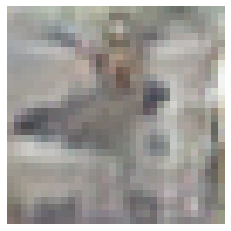

In [33]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

# load model

model = load_model('results_baseline/model_7800.h5')
# all 0s
vector = asarray([[0.75 for _ in range(200)]])

# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.axis('off')
pyplot.show()